In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
from sklearn.model_selection import train_test_split
import GPUtil

import matplotlib.colors as mcolors
import torch
import torch.nn as nn
from sklearn.preprocessing import Normalizer
import joblib
import ili  # Import ili for the SBI functionality
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

from sbi.utils.user_input_checks import process_prior

sys.path.append("/disk/xray15/aem2/camels/proj2")
from setup_params_1P import plot_uvlf, plot_colour
from setup_params_SB import *
from priors_SB import initialise_priors_SB28

from variables_config_28 import uvlf_limits, n_bins_lf, colour_limits, n_bins_colour
# parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
model = "IllustrisTNG"
spec_type = "attenuated"
sps = "BC03"
snap = ["044"]
bands = "all" # or just GALEX?

name = f"{model}_{bands}_{sps}_{spec_type}_{n_bins_lf}_{n_bins_colour}"

cam = camels(model=model, sim_set='SB28')

colours = False
luminosity_functions = True

if colours and not luminosity_functions: # colours only
    dir_to_inspect = '/disk/xray15/aem2/camels/proj2/SB_sims/hyp_pam_search_results/grid_search_results_colors_20241201_121508'
    plots_out_dir = '/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_best/colours_only' 

elif luminosity_functions and not colours: # lfs
    dir_to_inspect = '/disk/xray15/aem2/camels/proj2/SB_sims/hyp_pam_search_results/grid_search_results_20241201_105510'
    plots_out_dir = '/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_best/lfs_only' 

elif colours and luminosity_functions: # both
    dir_to_inspect = '/disk/xray15/aem2/camels/proj2/SB_sims/hyp_pam_search_results/grid_search_results_colors_lfs_20241201_121621'
    plots_out_dir = '/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_best/colours_lfs' 

else:
    raise ValueError("At least one of colours or luminosity_functions must be True")

print("Saving plots in ", plots_out_dir)
print("Getting grid results from ", dir_to_inspect)



Saving plots in  /disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_best/lfs_only
Getting grid results from  /disk/xray15/aem2/camels/proj2/SB_sims/hyp_pam_search_results/grid_search_results_20241201_105510


Get x and theta

          #Name    Omega0    sigma8  WindEnergyIn1e51erg  RadioFeedbackFactor  \
0        SB28_0  0.352541  0.694742              3.85743             1.519210   
1        SB28_1  0.172430  0.830154              1.03554             0.797734   
2        SB28_2  0.234683  0.705844              9.61416             3.380650   
3        SB28_3  0.440288  0.969259              2.14363             0.488165   
4        SB28_4  0.457152  0.786733              1.38466             0.325727   
...         ...       ...       ...                  ...                  ...   
2043  SB28_2043  0.457334  0.970226              8.89733             0.607197   
2044  SB28_2044  0.440496  0.786137              5.34131             0.880840   
2045  SB28_2045  0.234475  0.938760              1.49723             1.873430   
2046  SB28_2046  0.172613  0.612888             13.31250             0.363806   
2047  SB28_2047  0.352358  0.862216              3.09935             3.331570   

      VariableWindVelFactor

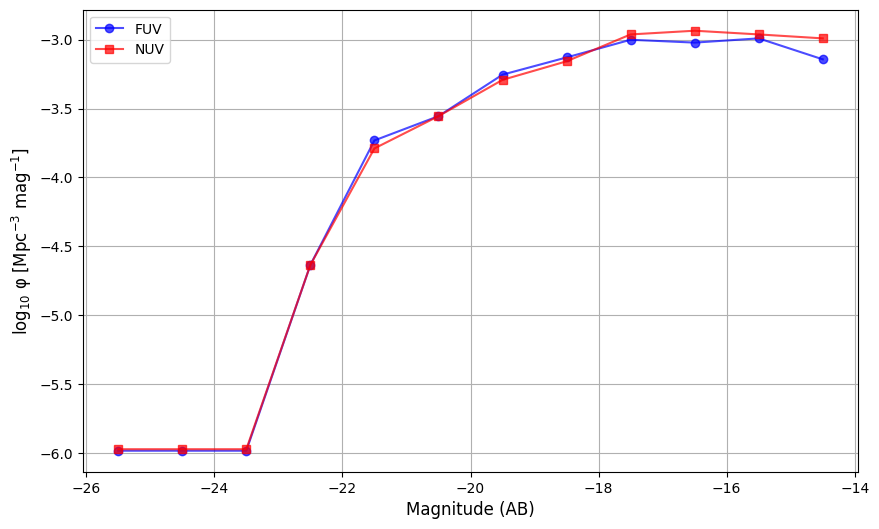

processing Omega0:
processing Omega0 is linear with min 0.1 and max 0.5:
processing sigma8:
processing sigma8 is linear with min 0.6 and max 1.0:
processing WindEnergyIn1e51erg:
processing WindEnergyIn1e51erg is logarithmic with min 0.9 and max 14.4:
processing RadioFeedbackFactor:
processing RadioFeedbackFactor is logarithmic with min 0.25 and max 4.0:
processing VariableWindVelFactor:
processing VariableWindVelFactor is logarithmic with min 3.7 and max 14.8:
processing RadioFeedbackReiorientationFactor:
processing RadioFeedbackReiorientationFactor is logarithmic with min 10.0 and max 40.0:
processing OmegaBaryon:
processing OmegaBaryon is linear with min 0.029 and max 0.069:
processing HubbleParam:
processing HubbleParam is linear with min 0.4711 and max 0.8711:
processing n_s:
processing n_s is linear with min 0.7624 and max 1.1624:
processing MaxSfrTimescale:
processing MaxSfrTimescale is logarithmic with min 1.135 and max 4.54:
processing FactorForSofterEQS:
processing FactorForSo

/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/user_input_checks.py:76: UserWarning: Prior was provided as a sequence of 28 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/sbi/utils/user_input_checks.py:209: UserWarning: Casting 1D Uniform prior to BoxUniform to match sbi batch requirements.
  warnings.warn(
/tmp/ipykernel_3238195/833724496.py:59: UserWarning: To copy construct from a

tensor([[-5.9821, -5.9821, -5.9821,  ..., -2.9353, -2.9622, -2.9908],
        [-5.9590, -5.9590, -5.9590,  ..., -2.5551, -2.4582, -2.3555],
        [-5.9826, -4.6343, -4.0322,  ..., -2.6898, -2.7650, -2.7205],
        ...,
        [-5.9753, -5.9753, -4.6343,  ..., -2.6566, -2.6898, -2.6214],
        [-5.9885, -5.9885, -5.9885,  ..., -3.4582, -3.5203, -3.6800],
        [-5.9836, -5.9836, -5.9836,  ..., -2.3671, -2.3888, -2.4913]],
       device='cuda:0')
theta: tensor([[3.5254e-01, 6.9474e-01, 3.8574e+00,  ..., 2.2539e-01, 2.6936e-04,
         5.1465e-01],
        [1.7243e-01, 8.3015e-01, 1.0355e+00,  ..., 8.6231e-02, 2.2802e-02,
         2.6208e+00],
        [2.3468e-01, 7.0584e-01, 9.6142e+00,  ..., 6.4810e-01, 1.4576e-03,
         3.3896e+00],
        ...,
        [2.3448e-01, 9.3876e-01, 1.4972e+00,  ..., 6.8262e-01, 6.2632e-03,
         3.1172e+00],
        [1.7261e-01, 6.1289e-01, 1.3312e+01,  ..., 8.3655e-02, 7.0985e-05,
         2.8879e+00],
        [3.5236e-01, 8.6222e-01, 3.09

In [2]:
# parameter info file (df_info) is used for defining priors
# the actual parameter values come from the camels class which reads CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt

#  parameters defined here: /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt which is used for theta
df_pars = pd.read_csv('/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt', delim_whitespace=True)
print(df_pars)


# prior values come from this:
df_info = pd.read_csv("/disk/xray15/aem2/data/28pams/Info_IllustrisTNG_L25n256_28params.txt")
print(df_info)

theta = df_pars.iloc[:, 1:29].to_numpy()  # excluding 'name' column and 'seed' column

print(theta)
print(theta.shape)
print("Column names:")
print(df_pars.columns.tolist())

if __name__ == "__main__":
    theta, x = get_theta_x_SB(
        luminosity_functions=luminosity_functions,
        colours=colours  # This will now override the default
    )
    print(theta.shape, x.shape)
    
if colours:
    fig = plot_colour(x)
    #plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/colours_test/colours/colour_check.png')
    plt.show()

if luminosity_functions:
    fig = plot_uvlf(x)
    #plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/LFs_test/uvlf_check.png')
    plt.show()


# get the priors and data
prior = initialise_priors_SB28(
    df=df_info, 
    device=device,
    astro=True,
    dust=False  # no dust for testing. set to False to only get the 28 model parameters.
    # with dust = True, prior has 32 dimensions (28 parameters + 4 dust parameters) 
)

# process the data
x_all = np.array([np.hstack(_x) for _x in x])
x_all = torch.tensor(x_all, dtype=torch.float32, device=device)

print("Theta shape:", theta.shape)
print("X shape:", x_all.shape)


# Move data to GPU as early as possible
x_all = x_all.to(device)
print('x_all:', x_all)

theta = torch.tensor(theta, dtype=torch.float32, device=device)
print('theta:', theta)

# Handle NaN values and normalize while on GPU
x_all_cpu = x_all.cpu().numpy()  # Only move to CPU when necessary for sklearn
print('x_all_cpu:', x_all_cpu)

print("Data shape before processing:", x_all_cpu.shape)
print("Number of values:",(x_all_cpu).sum())
print("Number of NaN values:", np.isnan(x_all_cpu).sum())
print("Number of infinite values:", np.isinf(x_all_cpu).sum())


# get rid of NaN/inf values, replace with small random noise
nan_mask = np.isnan(x_all_cpu) | np.isinf(x_all_cpu)
print('nan_mask:', nan_mask)


if nan_mask.any():
    x_all_cpu[nan_mask] = np.random.rand(np.sum(nan_mask)) * 1e-10

print("Data shape before processing:", x_all_cpu.shape)
print("Number of NaN values:", np.isnan(x_all_cpu).sum())
print("Number of infinite values:", np.isinf(x_all_cpu).sum())

print('x_all_cpu:', x_all_cpu)


# Normalize
norm = Normalizer()

# Option: Add small constant before normalizing
epsilon = 1e-10  # Small constant
x_all_shifted = x_all_cpu + epsilon
x_all_normalized = norm.fit_transform(x_all_shifted)
x_all = torch.tensor(x_all_normalized, dtype=torch.float32, device=device)

print('x_all:', x_all)

# make test mask
test_mask = create_test_mask() # 10% testing
train_mask = ~test_mask # 90% for training


Get best nn from parameter search

In [3]:
best_results = {}
best_val_loss = -1e10

for root, dirs, files in os.walk(dir_to_inspect, topdown=False):
   for name in files:
      if name == 'results.pkl':
        with open(os.path.join(root, name), 'rb') as f:
            x = pickle.load(f)
          
        # find 
        val_loss = max(x['summaries'][0]['validation_log_probs']) # pick value closest to 0
        if val_loss > best_val_loss:
          best_val_loss = val_loss
          best_results = x.copy()
          best_nn = files
          print(files)

['hf20_nt2_bs16_lr5e-05_nets2summary.json', 'results.pkl', 'hf20_nt2_bs16_lr5e-05_nets2posterior.pkl']
['hf20_nt2_bs16_lr1e-04_nets2posterior.pkl', 'results.pkl', 'hf20_nt2_bs16_lr1e-04_nets2summary.json']
['hf20_nt2_bs16_lr1e-04_nets1posterior.pkl', 'hf20_nt2_bs16_lr1e-04_nets1summary.json', 'results.pkl']
['hf20_nt2_bs16_lr1e-05_nets3summary.json', 'hf20_nt2_bs16_lr1e-05_nets3posterior.pkl', 'results.pkl']
['results.pkl', 'hf20_nt2_bs64_lr5e-05_nets3posterior.pkl', 'hf20_nt2_bs64_lr5e-05_nets3summary.json']


In [4]:
def create_run_name(params):
    """Create a descriptive run name from parameters"""
    return f"hf{params['hidden_features']}_nt{params['num_transforms']}_bs{params['training_batch_size']}_lr{params['learning_rate']:.0e}_nets{params['num_nets']}"

config_str = create_run_name(best_results['parameters'])
config_str

'hf20_nt2_bs64_lr5e-05_nets3'

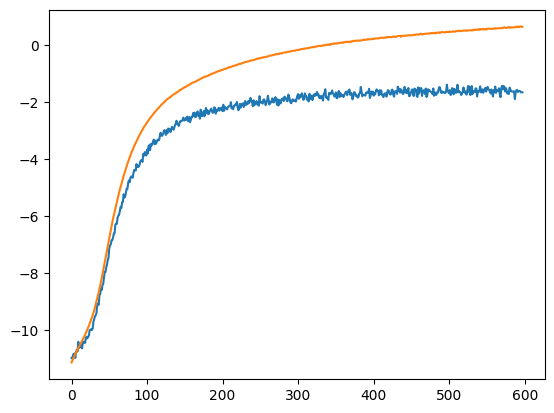

In [5]:
plt.plot(best_results['summaries'][0]['validation_log_probs'])
plt.plot(best_results['summaries'][0]['training_log_probs'])


In [6]:
posterior_ensemble = best_results['posterior_ensemble']

Get summaries

In [7]:

# Get test data
x_test = x_all[test_mask]
theta_test = theta[test_mask]

# Number of samples to draw from posterior
n_samples = 1000

# Storage for predictions
all_samples = []
all_means = []
all_stds = []

# Generate posterior samples for each test point
for i in range(len(x_test)):
    # Get samples from the posterior
    samples = posterior_ensemble.sample(
        (n_samples,), 
        x=x_test[i].reshape(1, -1)
    ).cpu().numpy()
    
    # Calculate mean and std of samples
    mean = samples.mean(axis=0)
    std = samples.std(axis=0)
    
    all_samples.append(samples)
    all_means.append(mean)
    all_stds.append(std)

all_samples = np.array(all_samples)
all_means = np.array(all_means)
all_stds = np.array(all_stds)

Drawing 362 posterior samples:   0%|          | 0/362 [00:00<?, ?it/s]

/disk/xray15/aem2/envs/camels/lib/python3.8/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2184.)
  outputs, _ = torch.triangular_solve(


Drawing 328 posterior samples:   0%|          | 0/328 [00:00<?, ?it/s]

Drawing 310 posterior samples:   0%|          | 0/310 [00:00<?, ?it/s]

Drawing 367 posterior samples:   0%|          | 0/367 [00:00<?, ?it/s]

Drawing 320 posterior samples:   0%|          | 0/320 [00:00<?, ?it/s]

Drawing 313 posterior samples:   0%|          | 0/313 [00:00<?, ?it/s]

Drawing 334 posterior samples:   0%|          | 0/334 [00:00<?, ?it/s]

Drawing 324 posterior samples:   0%|          | 0/324 [00:00<?, ?it/s]

Drawing 342 posterior samples:   0%|          | 0/342 [00:00<?, ?it/s]

Drawing 340 posterior samples:   0%|          | 0/340 [00:00<?, ?it/s]

Drawing 323 posterior samples:   0%|          | 0/323 [00:00<?, ?it/s]

Drawing 337 posterior samples:   0%|          | 0/337 [00:00<?, ?it/s]

Drawing 363 posterior samples:   0%|          | 0/363 [00:00<?, ?it/s]

Drawing 306 posterior samples:   0%|          | 0/306 [00:00<?, ?it/s]

Drawing 331 posterior samples:   0%|          | 0/331 [00:00<?, ?it/s]

Drawing 364 posterior samples:   0%|          | 0/364 [00:00<?, ?it/s]

Drawing 321 posterior samples:   0%|          | 0/321 [00:00<?, ?it/s]

Drawing 315 posterior samples:   0%|          | 0/315 [00:00<?, ?it/s]

Drawing 354 posterior samples:   0%|          | 0/354 [00:00<?, ?it/s]

Drawing 323 posterior samples:   0%|          | 0/323 [00:00<?, ?it/s]

Drawing 323 posterior samples:   0%|          | 0/323 [00:00<?, ?it/s]

Drawing 367 posterior samples:   0%|          | 0/367 [00:00<?, ?it/s]

Drawing 310 posterior samples:   0%|          | 0/310 [00:00<?, ?it/s]

Drawing 323 posterior samples:   0%|          | 0/323 [00:00<?, ?it/s]

Drawing 369 posterior samples:   0%|          | 0/369 [00:00<?, ?it/s]

Drawing 322 posterior samples:   0%|          | 0/322 [00:00<?, ?it/s]

Drawing 309 posterior samples:   0%|          | 0/309 [00:00<?, ?it/s]

Drawing 351 posterior samples:   0%|          | 0/351 [00:00<?, ?it/s]

Drawing 350 posterior samples:   0%|          | 0/350 [00:00<?, ?it/s]

Drawing 299 posterior samples:   0%|          | 0/299 [00:00<?, ?it/s]

Drawing 364 posterior samples:   0%|          | 0/364 [00:00<?, ?it/s]

Drawing 327 posterior samples:   0%|          | 0/327 [00:00<?, ?it/s]

Drawing 309 posterior samples:   0%|          | 0/309 [00:00<?, ?it/s]

Drawing 368 posterior samples:   0%|          | 0/368 [00:00<?, ?it/s]

Drawing 311 posterior samples:   0%|          | 0/311 [00:00<?, ?it/s]

Drawing 321 posterior samples:   0%|          | 0/321 [00:00<?, ?it/s]

Drawing 381 posterior samples:   0%|          | 0/381 [00:00<?, ?it/s]

Drawing 291 posterior samples:   0%|          | 0/291 [00:00<?, ?it/s]

Drawing 328 posterior samples:   0%|          | 0/328 [00:00<?, ?it/s]

Drawing 346 posterior samples:   0%|          | 0/346 [00:00<?, ?it/s]

Drawing 314 posterior samples:   0%|          | 0/314 [00:00<?, ?it/s]

Drawing 340 posterior samples:   0%|          | 0/340 [00:00<?, ?it/s]

Drawing 388 posterior samples:   0%|          | 0/388 [00:00<?, ?it/s]

Drawing 310 posterior samples:   0%|          | 0/310 [00:00<?, ?it/s]

Drawing 302 posterior samples:   0%|          | 0/302 [00:00<?, ?it/s]

Drawing 401 posterior samples:   0%|          | 0/401 [00:00<?, ?it/s]

Drawing 268 posterior samples:   0%|          | 0/268 [00:00<?, ?it/s]

Drawing 331 posterior samples:   0%|          | 0/331 [00:00<?, ?it/s]

Drawing 356 posterior samples:   0%|          | 0/356 [00:00<?, ?it/s]

Drawing 333 posterior samples:   0%|          | 0/333 [00:00<?, ?it/s]

Drawing 311 posterior samples:   0%|          | 0/311 [00:00<?, ?it/s]

Drawing 367 posterior samples:   0%|          | 0/367 [00:00<?, ?it/s]

Drawing 296 posterior samples:   0%|          | 0/296 [00:00<?, ?it/s]

Drawing 337 posterior samples:   0%|          | 0/337 [00:00<?, ?it/s]

Drawing 360 posterior samples:   0%|          | 0/360 [00:00<?, ?it/s]

Drawing 333 posterior samples:   0%|          | 0/333 [00:00<?, ?it/s]

Drawing 307 posterior samples:   0%|          | 0/307 [00:00<?, ?it/s]

Drawing 361 posterior samples:   0%|          | 0/361 [00:00<?, ?it/s]

Drawing 315 posterior samples:   0%|          | 0/315 [00:00<?, ?it/s]

Drawing 324 posterior samples:   0%|          | 0/324 [00:00<?, ?it/s]

Drawing 371 posterior samples:   0%|          | 0/371 [00:00<?, ?it/s]

Drawing 304 posterior samples:   0%|          | 0/304 [00:00<?, ?it/s]

Drawing 325 posterior samples:   0%|          | 0/325 [00:00<?, ?it/s]

Drawing 358 posterior samples:   0%|          | 0/358 [00:00<?, ?it/s]

Drawing 337 posterior samples:   0%|          | 0/337 [00:00<?, ?it/s]

Drawing 305 posterior samples:   0%|          | 0/305 [00:00<?, ?it/s]

Drawing 375 posterior samples:   0%|          | 0/375 [00:00<?, ?it/s]

Drawing 323 posterior samples:   0%|          | 0/323 [00:00<?, ?it/s]

Drawing 302 posterior samples:   0%|          | 0/302 [00:00<?, ?it/s]

Drawing 371 posterior samples:   0%|          | 0/371 [00:00<?, ?it/s]

Drawing 321 posterior samples:   0%|          | 0/321 [00:00<?, ?it/s]

Drawing 308 posterior samples:   0%|          | 0/308 [00:00<?, ?it/s]

Drawing 360 posterior samples:   0%|          | 0/360 [00:00<?, ?it/s]

Drawing 309 posterior samples:   0%|          | 0/309 [00:00<?, ?it/s]

Drawing 331 posterior samples:   0%|          | 0/331 [00:00<?, ?it/s]

Drawing 363 posterior samples:   0%|          | 0/363 [00:00<?, ?it/s]

Drawing 324 posterior samples:   0%|          | 0/324 [00:00<?, ?it/s]

Drawing 313 posterior samples:   0%|          | 0/313 [00:00<?, ?it/s]

Drawing 360 posterior samples:   0%|          | 0/360 [00:00<?, ?it/s]

Drawing 328 posterior samples:   0%|          | 0/328 [00:00<?, ?it/s]

Drawing 312 posterior samples:   0%|          | 0/312 [00:00<?, ?it/s]

Drawing 388 posterior samples:   0%|          | 0/388 [00:00<?, ?it/s]

Drawing 318 posterior samples:   0%|          | 0/318 [00:00<?, ?it/s]

Drawing 294 posterior samples:   0%|          | 0/294 [00:00<?, ?it/s]

Drawing 372 posterior samples:   0%|          | 0/372 [00:00<?, ?it/s]

Drawing 311 posterior samples:   0%|          | 0/311 [00:00<?, ?it/s]

Drawing 317 posterior samples:   0%|          | 0/317 [00:00<?, ?it/s]

Drawing 379 posterior samples:   0%|          | 0/379 [00:00<?, ?it/s]

Drawing 309 posterior samples:   0%|          | 0/309 [00:00<?, ?it/s]

Drawing 312 posterior samples:   0%|          | 0/312 [00:00<?, ?it/s]

Drawing 358 posterior samples:   0%|          | 0/358 [00:00<?, ?it/s]

Drawing 323 posterior samples:   0%|          | 0/323 [00:00<?, ?it/s]

Drawing 319 posterior samples:   0%|          | 0/319 [00:00<?, ?it/s]

Drawing 377 posterior samples:   0%|          | 0/377 [00:00<?, ?it/s]

Drawing 314 posterior samples:   0%|          | 0/314 [00:00<?, ?it/s]

Drawing 309 posterior samples:   0%|          | 0/309 [00:00<?, ?it/s]

Drawing 395 posterior samples:   0%|          | 0/395 [00:00<?, ?it/s]

Drawing 291 posterior samples:   0%|          | 0/291 [00:00<?, ?it/s]

Drawing 314 posterior samples:   0%|          | 0/314 [00:00<?, ?it/s]

Drawing 374 posterior samples:   0%|          | 0/374 [00:00<?, ?it/s]

Drawing 308 posterior samples:   0%|          | 0/308 [00:00<?, ?it/s]

Drawing 318 posterior samples:   0%|          | 0/318 [00:00<?, ?it/s]

Drawing 352 posterior samples:   0%|          | 0/352 [00:00<?, ?it/s]

Drawing 347 posterior samples:   0%|          | 0/347 [00:00<?, ?it/s]

Drawing 301 posterior samples:   0%|          | 0/301 [00:00<?, ?it/s]

Drawing 367 posterior samples:   0%|          | 0/367 [00:00<?, ?it/s]

Drawing 318 posterior samples:   0%|          | 0/318 [00:00<?, ?it/s]

Drawing 315 posterior samples:   0%|          | 0/315 [00:00<?, ?it/s]

Drawing 376 posterior samples:   0%|          | 0/376 [00:00<?, ?it/s]

Drawing 317 posterior samples:   0%|          | 0/317 [00:00<?, ?it/s]

Drawing 307 posterior samples:   0%|          | 0/307 [00:00<?, ?it/s]

Drawing 370 posterior samples:   0%|          | 0/370 [00:00<?, ?it/s]

Drawing 323 posterior samples:   0%|          | 0/323 [00:00<?, ?it/s]

Drawing 307 posterior samples:   0%|          | 0/307 [00:00<?, ?it/s]

Drawing 365 posterior samples:   0%|          | 0/365 [00:00<?, ?it/s]

Drawing 319 posterior samples:   0%|          | 0/319 [00:00<?, ?it/s]

Drawing 316 posterior samples:   0%|          | 0/316 [00:00<?, ?it/s]

Drawing 370 posterior samples:   0%|          | 0/370 [00:00<?, ?it/s]

Drawing 314 posterior samples:   0%|          | 0/314 [00:00<?, ?it/s]

Drawing 316 posterior samples:   0%|          | 0/316 [00:00<?, ?it/s]

Drawing 391 posterior samples:   0%|          | 0/391 [00:00<?, ?it/s]

Drawing 289 posterior samples:   0%|          | 0/289 [00:00<?, ?it/s]

Drawing 320 posterior samples:   0%|          | 0/320 [00:00<?, ?it/s]

Drawing 349 posterior samples:   0%|          | 0/349 [00:00<?, ?it/s]

Drawing 310 posterior samples:   0%|          | 0/310 [00:00<?, ?it/s]

Drawing 341 posterior samples:   0%|          | 0/341 [00:00<?, ?it/s]

Drawing 405 posterior samples:   0%|          | 0/405 [00:00<?, ?it/s]

Drawing 308 posterior samples:   0%|          | 0/308 [00:00<?, ?it/s]

Drawing 287 posterior samples:   0%|          | 0/287 [00:00<?, ?it/s]

Drawing 378 posterior samples:   0%|          | 0/378 [00:00<?, ?it/s]

Drawing 320 posterior samples:   0%|          | 0/320 [00:00<?, ?it/s]

Drawing 302 posterior samples:   0%|          | 0/302 [00:00<?, ?it/s]

Drawing 354 posterior samples:   0%|          | 0/354 [00:00<?, ?it/s]

Drawing 323 posterior samples:   0%|          | 0/323 [00:00<?, ?it/s]

Drawing 323 posterior samples:   0%|          | 0/323 [00:00<?, ?it/s]

Drawing 364 posterior samples:   0%|          | 0/364 [00:00<?, ?it/s]

Drawing 328 posterior samples:   0%|          | 0/328 [00:00<?, ?it/s]

Drawing 308 posterior samples:   0%|          | 0/308 [00:00<?, ?it/s]

Drawing 357 posterior samples:   0%|          | 0/357 [00:00<?, ?it/s]

Drawing 298 posterior samples:   0%|          | 0/298 [00:00<?, ?it/s]

Drawing 345 posterior samples:   0%|          | 0/345 [00:00<?, ?it/s]

Drawing 364 posterior samples:   0%|          | 0/364 [00:00<?, ?it/s]

Drawing 316 posterior samples:   0%|          | 0/316 [00:00<?, ?it/s]

Drawing 320 posterior samples:   0%|          | 0/320 [00:00<?, ?it/s]

Drawing 408 posterior samples:   0%|          | 0/408 [00:00<?, ?it/s]

Drawing 307 posterior samples:   0%|          | 0/307 [00:00<?, ?it/s]

Drawing 285 posterior samples:   0%|          | 0/285 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 306 posterior samples:   0%|          | 0/306 [00:00<?, ?it/s]

Drawing 279 posterior samples:   0%|          | 0/279 [00:00<?, ?it/s]

Drawing 352 posterior samples:   0%|          | 0/352 [00:00<?, ?it/s]

Drawing 327 posterior samples:   0%|          | 0/327 [00:00<?, ?it/s]

Drawing 321 posterior samples:   0%|          | 0/321 [00:00<?, ?it/s]

Drawing 379 posterior samples:   0%|          | 0/379 [00:00<?, ?it/s]

Drawing 329 posterior samples:   0%|          | 0/329 [00:00<?, ?it/s]

Drawing 292 posterior samples:   0%|          | 0/292 [00:00<?, ?it/s]

Drawing 385 posterior samples:   0%|          | 0/385 [00:00<?, ?it/s]

Drawing 292 posterior samples:   0%|          | 0/292 [00:00<?, ?it/s]

Drawing 323 posterior samples:   0%|          | 0/323 [00:00<?, ?it/s]

Drawing 388 posterior samples:   0%|          | 0/388 [00:00<?, ?it/s]

Drawing 296 posterior samples:   0%|          | 0/296 [00:00<?, ?it/s]

Drawing 316 posterior samples:   0%|          | 0/316 [00:00<?, ?it/s]

Drawing 359 posterior samples:   0%|          | 0/359 [00:00<?, ?it/s]

Drawing 321 posterior samples:   0%|          | 0/321 [00:00<?, ?it/s]

Drawing 320 posterior samples:   0%|          | 0/320 [00:00<?, ?it/s]

Drawing 358 posterior samples:   0%|          | 0/358 [00:00<?, ?it/s]

Drawing 332 posterior samples:   0%|          | 0/332 [00:00<?, ?it/s]

Drawing 310 posterior samples:   0%|          | 0/310 [00:00<?, ?it/s]

Drawing 355 posterior samples:   0%|          | 0/355 [00:00<?, ?it/s]

Drawing 315 posterior samples:   0%|          | 0/315 [00:00<?, ?it/s]

Drawing 330 posterior samples:   0%|          | 0/330 [00:00<?, ?it/s]

Drawing 385 posterior samples:   0%|          | 0/385 [00:00<?, ?it/s]

Drawing 298 posterior samples:   0%|          | 0/298 [00:00<?, ?it/s]

Drawing 317 posterior samples:   0%|          | 0/317 [00:00<?, ?it/s]

Drawing 337 posterior samples:   0%|          | 0/337 [00:00<?, ?it/s]

Drawing 346 posterior samples:   0%|          | 0/346 [00:00<?, ?it/s]

Drawing 317 posterior samples:   0%|          | 0/317 [00:00<?, ?it/s]

Drawing 351 posterior samples:   0%|          | 0/351 [00:00<?, ?it/s]

Drawing 334 posterior samples:   0%|          | 0/334 [00:00<?, ?it/s]

Drawing 315 posterior samples:   0%|          | 0/315 [00:00<?, ?it/s]

Drawing 373 posterior samples:   0%|          | 0/373 [00:00<?, ?it/s]

Drawing 312 posterior samples:   0%|          | 0/312 [00:00<?, ?it/s]

Drawing 315 posterior samples:   0%|          | 0/315 [00:00<?, ?it/s]

Drawing 358 posterior samples:   0%|          | 0/358 [00:00<?, ?it/s]

Drawing 340 posterior samples:   0%|          | 0/340 [00:00<?, ?it/s]

Drawing 302 posterior samples:   0%|          | 0/302 [00:00<?, ?it/s]

Drawing 366 posterior samples:   0%|          | 0/366 [00:00<?, ?it/s]

Drawing 321 posterior samples:   0%|          | 0/321 [00:00<?, ?it/s]

Drawing 313 posterior samples:   0%|          | 0/313 [00:00<?, ?it/s]

Drawing 375 posterior samples:   0%|          | 0/375 [00:00<?, ?it/s]

Drawing 303 posterior samples:   0%|          | 0/303 [00:00<?, ?it/s]

Drawing 322 posterior samples:   0%|          | 0/322 [00:00<?, ?it/s]

Drawing 372 posterior samples:   0%|          | 0/372 [00:00<?, ?it/s]

Drawing 348 posterior samples:   0%|          | 0/348 [00:00<?, ?it/s]

Drawing 280 posterior samples:   0%|          | 0/280 [00:00<?, ?it/s]

Drawing 377 posterior samples:   0%|          | 0/377 [00:00<?, ?it/s]

Drawing 320 posterior samples:   0%|          | 0/320 [00:00<?, ?it/s]

Drawing 303 posterior samples:   0%|          | 0/303 [00:00<?, ?it/s]

Drawing 374 posterior samples:   0%|          | 0/374 [00:00<?, ?it/s]

Drawing 306 posterior samples:   0%|          | 0/306 [00:00<?, ?it/s]

Drawing 320 posterior samples:   0%|          | 0/320 [00:00<?, ?it/s]

Drawing 366 posterior samples:   0%|          | 0/366 [00:00<?, ?it/s]

Drawing 342 posterior samples:   0%|          | 0/342 [00:00<?, ?it/s]

Drawing 292 posterior samples:   0%|          | 0/292 [00:00<?, ?it/s]

Drawing 364 posterior samples:   0%|          | 0/364 [00:00<?, ?it/s]

Drawing 321 posterior samples:   0%|          | 0/321 [00:00<?, ?it/s]

Drawing 315 posterior samples:   0%|          | 0/315 [00:00<?, ?it/s]

Drawing 382 posterior samples:   0%|          | 0/382 [00:00<?, ?it/s]

Drawing 307 posterior samples:   0%|          | 0/307 [00:00<?, ?it/s]

Drawing 311 posterior samples:   0%|          | 0/311 [00:00<?, ?it/s]

Drawing 361 posterior samples:   0%|          | 0/361 [00:00<?, ?it/s]

Drawing 314 posterior samples:   0%|          | 0/314 [00:00<?, ?it/s]

Drawing 325 posterior samples:   0%|          | 0/325 [00:00<?, ?it/s]

Drawing 360 posterior samples:   0%|          | 0/360 [00:00<?, ?it/s]

Drawing 321 posterior samples:   0%|          | 0/321 [00:00<?, ?it/s]

Drawing 319 posterior samples:   0%|          | 0/319 [00:00<?, ?it/s]

Drawing 368 posterior samples:   0%|          | 0/368 [00:00<?, ?it/s]

Drawing 288 posterior samples:   0%|          | 0/288 [00:00<?, ?it/s]

Drawing 344 posterior samples:   0%|          | 0/344 [00:00<?, ?it/s]

Drawing 354 posterior samples:   0%|          | 0/354 [00:00<?, ?it/s]

Drawing 347 posterior samples:   0%|          | 0/347 [00:00<?, ?it/s]

Drawing 299 posterior samples:   0%|          | 0/299 [00:00<?, ?it/s]

Drawing 395 posterior samples:   0%|          | 0/395 [00:00<?, ?it/s]

Drawing 291 posterior samples:   0%|          | 0/291 [00:00<?, ?it/s]

Drawing 314 posterior samples:   0%|          | 0/314 [00:00<?, ?it/s]

Drawing 385 posterior samples:   0%|          | 0/385 [00:00<?, ?it/s]

Drawing 314 posterior samples:   0%|          | 0/314 [00:00<?, ?it/s]

Drawing 301 posterior samples:   0%|          | 0/301 [00:00<?, ?it/s]

Drawing 366 posterior samples:   0%|          | 0/366 [00:00<?, ?it/s]

Drawing 342 posterior samples:   0%|          | 0/342 [00:00<?, ?it/s]

Drawing 292 posterior samples:   0%|          | 0/292 [00:00<?, ?it/s]

Drawing 380 posterior samples:   0%|          | 0/380 [00:00<?, ?it/s]

Drawing 328 posterior samples:   0%|          | 0/328 [00:00<?, ?it/s]

Drawing 292 posterior samples:   0%|          | 0/292 [00:00<?, ?it/s]

Drawing 367 posterior samples:   0%|          | 0/367 [00:00<?, ?it/s]

Drawing 328 posterior samples:   0%|          | 0/328 [00:00<?, ?it/s]

Drawing 305 posterior samples:   0%|          | 0/305 [00:00<?, ?it/s]

Drawing 387 posterior samples:   0%|          | 0/387 [00:00<?, ?it/s]

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Drawing 313 posterior samples:   0%|          | 0/313 [00:00<?, ?it/s]

Drawing 339 posterior samples:   0%|          | 0/339 [00:00<?, ?it/s]

Drawing 337 posterior samples:   0%|          | 0/337 [00:00<?, ?it/s]

Drawing 324 posterior samples:   0%|          | 0/324 [00:00<?, ?it/s]

Drawing 383 posterior samples:   0%|          | 0/383 [00:00<?, ?it/s]

Drawing 310 posterior samples:   0%|          | 0/310 [00:00<?, ?it/s]

Drawing 307 posterior samples:   0%|          | 0/307 [00:00<?, ?it/s]

Drawing 386 posterior samples:   0%|          | 0/386 [00:00<?, ?it/s]

Drawing 316 posterior samples:   0%|          | 0/316 [00:00<?, ?it/s]

Drawing 298 posterior samples:   0%|          | 0/298 [00:00<?, ?it/s]

Drawing 381 posterior samples:   0%|          | 0/381 [00:00<?, ?it/s]

Drawing 309 posterior samples:   0%|          | 0/309 [00:00<?, ?it/s]

Drawing 310 posterior samples:   0%|          | 0/310 [00:00<?, ?it/s]

Drawing 364 posterior samples:   0%|          | 0/364 [00:00<?, ?it/s]

Drawing 301 posterior samples:   0%|          | 0/301 [00:00<?, ?it/s]

Drawing 335 posterior samples:   0%|          | 0/335 [00:00<?, ?it/s]

Drawing 377 posterior samples:   0%|          | 0/377 [00:00<?, ?it/s]

Drawing 307 posterior samples:   0%|          | 0/307 [00:00<?, ?it/s]

Drawing 316 posterior samples:   0%|          | 0/316 [00:00<?, ?it/s]

Drawing 366 posterior samples:   0%|          | 0/366 [00:00<?, ?it/s]

Drawing 347 posterior samples:   0%|          | 0/347 [00:00<?, ?it/s]

Drawing 287 posterior samples:   0%|          | 0/287 [00:00<?, ?it/s]

Drawing 383 posterior samples:   0%|          | 0/383 [00:00<?, ?it/s]

Drawing 298 posterior samples:   0%|          | 0/298 [00:00<?, ?it/s]

Drawing 319 posterior samples:   0%|          | 0/319 [00:00<?, ?it/s]

Drawing 352 posterior samples:   0%|          | 0/352 [00:00<?, ?it/s]

Drawing 329 posterior samples:   0%|          | 0/329 [00:00<?, ?it/s]

Drawing 319 posterior samples:   0%|          | 0/319 [00:00<?, ?it/s]

Drawing 379 posterior samples:   0%|          | 0/379 [00:00<?, ?it/s]

Drawing 324 posterior samples:   0%|          | 0/324 [00:00<?, ?it/s]

Drawing 297 posterior samples:   0%|          | 0/297 [00:00<?, ?it/s]

Drawing 382 posterior samples:   0%|          | 0/382 [00:00<?, ?it/s]

Drawing 322 posterior samples:   0%|          | 0/322 [00:00<?, ?it/s]

Drawing 296 posterior samples:   0%|          | 0/296 [00:00<?, ?it/s]

Drawing 348 posterior samples:   0%|          | 0/348 [00:00<?, ?it/s]

Drawing 326 posterior samples:   0%|          | 0/326 [00:00<?, ?it/s]

Drawing 326 posterior samples:   0%|          | 0/326 [00:00<?, ?it/s]

Drawing 372 posterior samples:   0%|          | 0/372 [00:00<?, ?it/s]

Drawing 346 posterior samples:   0%|          | 0/346 [00:00<?, ?it/s]

Drawing 282 posterior samples:   0%|          | 0/282 [00:00<?, ?it/s]

Drawing 362 posterior samples:   0%|          | 0/362 [00:00<?, ?it/s]

Drawing 333 posterior samples:   0%|          | 0/333 [00:00<?, ?it/s]

Drawing 305 posterior samples:   0%|          | 0/305 [00:00<?, ?it/s]

Drawing 363 posterior samples:   0%|          | 0/363 [00:00<?, ?it/s]

Drawing 334 posterior samples:   0%|          | 0/334 [00:00<?, ?it/s]

Drawing 303 posterior samples:   0%|          | 0/303 [00:00<?, ?it/s]

Drawing 350 posterior samples:   0%|          | 0/350 [00:00<?, ?it/s]

Drawing 325 posterior samples:   0%|          | 0/325 [00:00<?, ?it/s]

Drawing 325 posterior samples:   0%|          | 0/325 [00:00<?, ?it/s]

Drawing 343 posterior samples:   0%|          | 0/343 [00:00<?, ?it/s]

Drawing 335 posterior samples:   0%|          | 0/335 [00:00<?, ?it/s]

Drawing 322 posterior samples:   0%|          | 0/322 [00:00<?, ?it/s]

Drawing 368 posterior samples:   0%|          | 0/368 [00:00<?, ?it/s]

Drawing 329 posterior samples:   0%|          | 0/329 [00:00<?, ?it/s]

Drawing 303 posterior samples:   0%|          | 0/303 [00:00<?, ?it/s]

Drawing 356 posterior samples:   0%|          | 0/356 [00:00<?, ?it/s]

Drawing 336 posterior samples:   0%|          | 0/336 [00:00<?, ?it/s]

Drawing 308 posterior samples:   0%|          | 0/308 [00:00<?, ?it/s]

Drawing 335 posterior samples:   0%|          | 0/335 [00:00<?, ?it/s]

Drawing 333 posterior samples:   0%|          | 0/333 [00:00<?, ?it/s]

Drawing 332 posterior samples:   0%|          | 0/332 [00:00<?, ?it/s]

Drawing 398 posterior samples:   0%|          | 0/398 [00:00<?, ?it/s]

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Drawing 302 posterior samples:   0%|          | 0/302 [00:00<?, ?it/s]

Drawing 361 posterior samples:   0%|          | 0/361 [00:00<?, ?it/s]

Drawing 330 posterior samples:   0%|          | 0/330 [00:00<?, ?it/s]

Drawing 309 posterior samples:   0%|          | 0/309 [00:00<?, ?it/s]

Drawing 372 posterior samples:   0%|          | 0/372 [00:00<?, ?it/s]

Drawing 324 posterior samples:   0%|          | 0/324 [00:00<?, ?it/s]

Drawing 304 posterior samples:   0%|          | 0/304 [00:00<?, ?it/s]

Drawing 359 posterior samples:   0%|          | 0/359 [00:00<?, ?it/s]

Drawing 316 posterior samples:   0%|          | 0/316 [00:00<?, ?it/s]

Drawing 325 posterior samples:   0%|          | 0/325 [00:00<?, ?it/s]

Drawing 363 posterior samples:   0%|          | 0/363 [00:00<?, ?it/s]

Drawing 307 posterior samples:   0%|          | 0/307 [00:00<?, ?it/s]

Drawing 330 posterior samples:   0%|          | 0/330 [00:00<?, ?it/s]

Drawing 377 posterior samples:   0%|          | 0/377 [00:00<?, ?it/s]

Drawing 308 posterior samples:   0%|          | 0/308 [00:00<?, ?it/s]

Drawing 315 posterior samples:   0%|          | 0/315 [00:00<?, ?it/s]

Drawing 345 posterior samples:   0%|          | 0/345 [00:00<?, ?it/s]

Drawing 334 posterior samples:   0%|          | 0/334 [00:00<?, ?it/s]

Drawing 321 posterior samples:   0%|          | 0/321 [00:00<?, ?it/s]

Drawing 348 posterior samples:   0%|          | 0/348 [00:00<?, ?it/s]

Drawing 344 posterior samples:   0%|          | 0/344 [00:00<?, ?it/s]

Drawing 308 posterior samples:   0%|          | 0/308 [00:00<?, ?it/s]

Drawing 368 posterior samples:   0%|          | 0/368 [00:00<?, ?it/s]

Drawing 344 posterior samples:   0%|          | 0/344 [00:00<?, ?it/s]

Drawing 288 posterior samples:   0%|          | 0/288 [00:00<?, ?it/s]

Drawing 344 posterior samples:   0%|          | 0/344 [00:00<?, ?it/s]

Drawing 296 posterior samples:   0%|          | 0/296 [00:00<?, ?it/s]

Drawing 360 posterior samples:   0%|          | 0/360 [00:00<?, ?it/s]

Drawing 394 posterior samples:   0%|          | 0/394 [00:00<?, ?it/s]

Drawing 314 posterior samples:   0%|          | 0/314 [00:00<?, ?it/s]

Drawing 292 posterior samples:   0%|          | 0/292 [00:00<?, ?it/s]

Drawing 369 posterior samples:   0%|          | 0/369 [00:00<?, ?it/s]

Drawing 318 posterior samples:   0%|          | 0/318 [00:00<?, ?it/s]

Drawing 313 posterior samples:   0%|          | 0/313 [00:00<?, ?it/s]

Drawing 391 posterior samples:   0%|          | 0/391 [00:00<?, ?it/s]

Drawing 319 posterior samples:   0%|          | 0/319 [00:00<?, ?it/s]

Drawing 290 posterior samples:   0%|          | 0/290 [00:00<?, ?it/s]

Drawing 388 posterior samples:   0%|          | 0/388 [00:00<?, ?it/s]

Drawing 316 posterior samples:   0%|          | 0/316 [00:00<?, ?it/s]

Drawing 296 posterior samples:   0%|          | 0/296 [00:00<?, ?it/s]

Drawing 376 posterior samples:   0%|          | 0/376 [00:00<?, ?it/s]

Drawing 310 posterior samples:   0%|          | 0/310 [00:00<?, ?it/s]

Drawing 314 posterior samples:   0%|          | 0/314 [00:00<?, ?it/s]

Drawing 401 posterior samples:   0%|          | 0/401 [00:00<?, ?it/s]

Drawing 293 posterior samples:   0%|          | 0/293 [00:00<?, ?it/s]

Drawing 306 posterior samples:   0%|          | 0/306 [00:00<?, ?it/s]

Drawing 345 posterior samples:   0%|          | 0/345 [00:00<?, ?it/s]

Drawing 334 posterior samples:   0%|          | 0/334 [00:00<?, ?it/s]

Drawing 321 posterior samples:   0%|          | 0/321 [00:00<?, ?it/s]

Drawing 344 posterior samples:   0%|          | 0/344 [00:00<?, ?it/s]

Drawing 338 posterior samples:   0%|          | 0/338 [00:00<?, ?it/s]

Drawing 318 posterior samples:   0%|          | 0/318 [00:00<?, ?it/s]

Drawing 353 posterior samples:   0%|          | 0/353 [00:00<?, ?it/s]

Drawing 316 posterior samples:   0%|          | 0/316 [00:00<?, ?it/s]

Drawing 331 posterior samples:   0%|          | 0/331 [00:00<?, ?it/s]

Drawing 376 posterior samples:   0%|          | 0/376 [00:00<?, ?it/s]

Drawing 312 posterior samples:   0%|          | 0/312 [00:00<?, ?it/s]

Drawing 312 posterior samples:   0%|          | 0/312 [00:00<?, ?it/s]

Drawing 374 posterior samples:   0%|          | 0/374 [00:00<?, ?it/s]

Drawing 315 posterior samples:   0%|          | 0/315 [00:00<?, ?it/s]

Drawing 311 posterior samples:   0%|          | 0/311 [00:00<?, ?it/s]

Drawing 366 posterior samples:   0%|          | 0/366 [00:00<?, ?it/s]

Drawing 343 posterior samples:   0%|          | 0/343 [00:00<?, ?it/s]

Drawing 291 posterior samples:   0%|          | 0/291 [00:00<?, ?it/s]

Drawing 366 posterior samples:   0%|          | 0/366 [00:00<?, ?it/s]

Drawing 314 posterior samples:   0%|          | 0/314 [00:00<?, ?it/s]

Drawing 320 posterior samples:   0%|          | 0/320 [00:00<?, ?it/s]

Drawing 380 posterior samples:   0%|          | 0/380 [00:00<?, ?it/s]

Drawing 311 posterior samples:   0%|          | 0/311 [00:00<?, ?it/s]

Drawing 309 posterior samples:   0%|          | 0/309 [00:00<?, ?it/s]

Drawing 369 posterior samples:   0%|          | 0/369 [00:00<?, ?it/s]

Drawing 317 posterior samples:   0%|          | 0/317 [00:00<?, ?it/s]

Drawing 314 posterior samples:   0%|          | 0/314 [00:00<?, ?it/s]

Drawing 371 posterior samples:   0%|          | 0/371 [00:00<?, ?it/s]

Drawing 324 posterior samples:   0%|          | 0/324 [00:00<?, ?it/s]

Drawing 305 posterior samples:   0%|          | 0/305 [00:00<?, ?it/s]

Drawing 368 posterior samples:   0%|          | 0/368 [00:00<?, ?it/s]

Drawing 314 posterior samples:   0%|          | 0/314 [00:00<?, ?it/s]

Drawing 318 posterior samples:   0%|          | 0/318 [00:00<?, ?it/s]

Drawing 364 posterior samples:   0%|          | 0/364 [00:00<?, ?it/s]

Drawing 321 posterior samples:   0%|          | 0/321 [00:00<?, ?it/s]

Drawing 315 posterior samples:   0%|          | 0/315 [00:00<?, ?it/s]

Drawing 377 posterior samples:   0%|          | 0/377 [00:00<?, ?it/s]

Drawing 336 posterior samples:   0%|          | 0/336 [00:00<?, ?it/s]

Drawing 287 posterior samples:   0%|          | 0/287 [00:00<?, ?it/s]

Drawing 374 posterior samples:   0%|          | 0/374 [00:00<?, ?it/s]

Drawing 315 posterior samples:   0%|          | 0/315 [00:00<?, ?it/s]

Drawing 311 posterior samples:   0%|          | 0/311 [00:00<?, ?it/s]

Drawing 373 posterior samples:   0%|          | 0/373 [00:00<?, ?it/s]

Drawing 296 posterior samples:   0%|          | 0/296 [00:00<?, ?it/s]

Drawing 331 posterior samples:   0%|          | 0/331 [00:00<?, ?it/s]

Drawing 366 posterior samples:   0%|          | 0/366 [00:00<?, ?it/s]

Drawing 355 posterior samples:   0%|          | 0/355 [00:00<?, ?it/s]

Drawing 279 posterior samples:   0%|          | 0/279 [00:00<?, ?it/s]

Drawing 375 posterior samples:   0%|          | 0/375 [00:00<?, ?it/s]

Drawing 327 posterior samples:   0%|          | 0/327 [00:00<?, ?it/s]

Drawing 298 posterior samples:   0%|          | 0/298 [00:00<?, ?it/s]

Drawing 363 posterior samples:   0%|          | 0/363 [00:00<?, ?it/s]

Drawing 328 posterior samples:   0%|          | 0/328 [00:00<?, ?it/s]

Drawing 309 posterior samples:   0%|          | 0/309 [00:00<?, ?it/s]

Drawing 384 posterior samples:   0%|          | 0/384 [00:00<?, ?it/s]

Drawing 297 posterior samples:   0%|          | 0/297 [00:00<?, ?it/s]

Drawing 319 posterior samples:   0%|          | 0/319 [00:00<?, ?it/s]

Drawing 348 posterior samples:   0%|          | 0/348 [00:00<?, ?it/s]

Drawing 329 posterior samples:   0%|          | 0/329 [00:00<?, ?it/s]

Drawing 323 posterior samples:   0%|          | 0/323 [00:00<?, ?it/s]

Drawing 415 posterior samples:   0%|          | 0/415 [00:00<?, ?it/s]

Drawing 275 posterior samples:   0%|          | 0/275 [00:00<?, ?it/s]

Drawing 310 posterior samples:   0%|          | 0/310 [00:00<?, ?it/s]

Drawing 385 posterior samples:   0%|          | 0/385 [00:00<?, ?it/s]

Drawing 297 posterior samples:   0%|          | 0/297 [00:00<?, ?it/s]

Drawing 318 posterior samples:   0%|          | 0/318 [00:00<?, ?it/s]

Drawing 340 posterior samples:   0%|          | 0/340 [00:00<?, ?it/s]

Drawing 323 posterior samples:   0%|          | 0/323 [00:00<?, ?it/s]

Drawing 337 posterior samples:   0%|          | 0/337 [00:00<?, ?it/s]

Drawing 382 posterior samples:   0%|          | 0/382 [00:00<?, ?it/s]

Drawing 319 posterior samples:   0%|          | 0/319 [00:00<?, ?it/s]

Drawing 299 posterior samples:   0%|          | 0/299 [00:00<?, ?it/s]

Drawing 401 posterior samples:   0%|          | 0/401 [00:00<?, ?it/s]

Drawing 313 posterior samples:   0%|          | 0/313 [00:00<?, ?it/s]

Drawing 286 posterior samples:   0%|          | 0/286 [00:00<?, ?it/s]

Drawing 363 posterior samples:   0%|          | 0/363 [00:00<?, ?it/s]

Drawing 342 posterior samples:   0%|          | 0/342 [00:00<?, ?it/s]

Drawing 295 posterior samples:   0%|          | 0/295 [00:00<?, ?it/s]

Drawing 359 posterior samples:   0%|          | 0/359 [00:00<?, ?it/s]

Drawing 338 posterior samples:   0%|          | 0/338 [00:00<?, ?it/s]

Drawing 303 posterior samples:   0%|          | 0/303 [00:00<?, ?it/s]

Drawing 370 posterior samples:   0%|          | 0/370 [00:00<?, ?it/s]

Drawing 309 posterior samples:   0%|          | 0/309 [00:00<?, ?it/s]

Drawing 321 posterior samples:   0%|          | 0/321 [00:00<?, ?it/s]

Drawing 359 posterior samples:   0%|          | 0/359 [00:00<?, ?it/s]

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Drawing 341 posterior samples:   0%|          | 0/341 [00:00<?, ?it/s]

Drawing 351 posterior samples:   0%|          | 0/351 [00:00<?, ?it/s]

Drawing 354 posterior samples:   0%|          | 0/354 [00:00<?, ?it/s]

Drawing 295 posterior samples:   0%|          | 0/295 [00:00<?, ?it/s]

Drawing 376 posterior samples:   0%|          | 0/376 [00:00<?, ?it/s]

Drawing 313 posterior samples:   0%|          | 0/313 [00:00<?, ?it/s]

Drawing 311 posterior samples:   0%|          | 0/311 [00:00<?, ?it/s]

Drawing 398 posterior samples:   0%|          | 0/398 [00:00<?, ?it/s]

Drawing 311 posterior samples:   0%|          | 0/311 [00:00<?, ?it/s]

Drawing 291 posterior samples:   0%|          | 0/291 [00:00<?, ?it/s]

Drawing 341 posterior samples:   0%|          | 0/341 [00:00<?, ?it/s]

Drawing 333 posterior samples:   0%|          | 0/333 [00:00<?, ?it/s]

Drawing 326 posterior samples:   0%|          | 0/326 [00:00<?, ?it/s]

Drawing 349 posterior samples:   0%|          | 0/349 [00:00<?, ?it/s]

Drawing 344 posterior samples:   0%|          | 0/344 [00:00<?, ?it/s]

Drawing 307 posterior samples:   0%|          | 0/307 [00:00<?, ?it/s]

Drawing 371 posterior samples:   0%|          | 0/371 [00:00<?, ?it/s]

Drawing 318 posterior samples:   0%|          | 0/318 [00:00<?, ?it/s]

Drawing 311 posterior samples:   0%|          | 0/311 [00:00<?, ?it/s]

Drawing 372 posterior samples:   0%|          | 0/372 [00:00<?, ?it/s]

Drawing 308 posterior samples:   0%|          | 0/308 [00:00<?, ?it/s]

Drawing 320 posterior samples:   0%|          | 0/320 [00:00<?, ?it/s]

Drawing 351 posterior samples:   0%|          | 0/351 [00:00<?, ?it/s]

Drawing 301 posterior samples:   0%|          | 0/301 [00:00<?, ?it/s]

Drawing 348 posterior samples:   0%|          | 0/348 [00:00<?, ?it/s]

Drawing 389 posterior samples:   0%|          | 0/389 [00:00<?, ?it/s]

Drawing 307 posterior samples:   0%|          | 0/307 [00:00<?, ?it/s]

Drawing 304 posterior samples:   0%|          | 0/304 [00:00<?, ?it/s]

Drawing 355 posterior samples:   0%|          | 0/355 [00:00<?, ?it/s]

Drawing 319 posterior samples:   0%|          | 0/319 [00:00<?, ?it/s]

Drawing 326 posterior samples:   0%|          | 0/326 [00:00<?, ?it/s]

Drawing 375 posterior samples:   0%|          | 0/375 [00:00<?, ?it/s]

Drawing 307 posterior samples:   0%|          | 0/307 [00:00<?, ?it/s]

Drawing 318 posterior samples:   0%|          | 0/318 [00:00<?, ?it/s]

Drawing 371 posterior samples:   0%|          | 0/371 [00:00<?, ?it/s]

Drawing 317 posterior samples:   0%|          | 0/317 [00:00<?, ?it/s]

Drawing 312 posterior samples:   0%|          | 0/312 [00:00<?, ?it/s]

Drawing 380 posterior samples:   0%|          | 0/380 [00:00<?, ?it/s]

Drawing 334 posterior samples:   0%|          | 0/334 [00:00<?, ?it/s]

Drawing 286 posterior samples:   0%|          | 0/286 [00:00<?, ?it/s]

Drawing 390 posterior samples:   0%|          | 0/390 [00:00<?, ?it/s]

Drawing 284 posterior samples:   0%|          | 0/284 [00:00<?, ?it/s]

Drawing 326 posterior samples:   0%|          | 0/326 [00:00<?, ?it/s]

Drawing 362 posterior samples:   0%|          | 0/362 [00:00<?, ?it/s]

Drawing 325 posterior samples:   0%|          | 0/325 [00:00<?, ?it/s]

Drawing 313 posterior samples:   0%|          | 0/313 [00:00<?, ?it/s]

Drawing 361 posterior samples:   0%|          | 0/361 [00:00<?, ?it/s]

Drawing 345 posterior samples:   0%|          | 0/345 [00:00<?, ?it/s]

Drawing 294 posterior samples:   0%|          | 0/294 [00:00<?, ?it/s]

Drawing 366 posterior samples:   0%|          | 0/366 [00:00<?, ?it/s]

Drawing 332 posterior samples:   0%|          | 0/332 [00:00<?, ?it/s]

Drawing 302 posterior samples:   0%|          | 0/302 [00:00<?, ?it/s]

Drawing 356 posterior samples:   0%|          | 0/356 [00:00<?, ?it/s]

Drawing 332 posterior samples:   0%|          | 0/332 [00:00<?, ?it/s]

Drawing 312 posterior samples:   0%|          | 0/312 [00:00<?, ?it/s]

Drawing 374 posterior samples:   0%|          | 0/374 [00:00<?, ?it/s]

Drawing 297 posterior samples:   0%|          | 0/297 [00:00<?, ?it/s]

Drawing 329 posterior samples:   0%|          | 0/329 [00:00<?, ?it/s]

Drawing 387 posterior samples:   0%|          | 0/387 [00:00<?, ?it/s]

Drawing 316 posterior samples:   0%|          | 0/316 [00:00<?, ?it/s]

Drawing 297 posterior samples:   0%|          | 0/297 [00:00<?, ?it/s]

Drawing 402 posterior samples:   0%|          | 0/402 [00:00<?, ?it/s]

Drawing 303 posterior samples:   0%|          | 0/303 [00:00<?, ?it/s]

Drawing 295 posterior samples:   0%|          | 0/295 [00:00<?, ?it/s]

Drawing 378 posterior samples:   0%|          | 0/378 [00:00<?, ?it/s]

Drawing 297 posterior samples:   0%|          | 0/297 [00:00<?, ?it/s]

Drawing 325 posterior samples:   0%|          | 0/325 [00:00<?, ?it/s]

Drawing 361 posterior samples:   0%|          | 0/361 [00:00<?, ?it/s]

Drawing 339 posterior samples:   0%|          | 0/339 [00:00<?, ?it/s]

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Drawing 382 posterior samples:   0%|          | 0/382 [00:00<?, ?it/s]

Drawing 299 posterior samples:   0%|          | 0/299 [00:00<?, ?it/s]

Drawing 319 posterior samples:   0%|          | 0/319 [00:00<?, ?it/s]

Drawing 354 posterior samples:   0%|          | 0/354 [00:00<?, ?it/s]

Drawing 328 posterior samples:   0%|          | 0/328 [00:00<?, ?it/s]

Drawing 318 posterior samples:   0%|          | 0/318 [00:00<?, ?it/s]

Drawing 360 posterior samples:   0%|          | 0/360 [00:00<?, ?it/s]

Drawing 316 posterior samples:   0%|          | 0/316 [00:00<?, ?it/s]

Drawing 324 posterior samples:   0%|          | 0/324 [00:00<?, ?it/s]

Drawing 342 posterior samples:   0%|          | 0/342 [00:00<?, ?it/s]

Drawing 349 posterior samples:   0%|          | 0/349 [00:00<?, ?it/s]

Drawing 309 posterior samples:   0%|          | 0/309 [00:00<?, ?it/s]

Drawing 384 posterior samples:   0%|          | 0/384 [00:00<?, ?it/s]

Drawing 303 posterior samples:   0%|          | 0/303 [00:00<?, ?it/s]

Drawing 313 posterior samples:   0%|          | 0/313 [00:00<?, ?it/s]

Drawing 350 posterior samples:   0%|          | 0/350 [00:00<?, ?it/s]

Drawing 337 posterior samples:   0%|          | 0/337 [00:00<?, ?it/s]

Drawing 313 posterior samples:   0%|          | 0/313 [00:00<?, ?it/s]

Drawing 370 posterior samples:   0%|          | 0/370 [00:00<?, ?it/s]

Drawing 334 posterior samples:   0%|          | 0/334 [00:00<?, ?it/s]

Drawing 296 posterior samples:   0%|          | 0/296 [00:00<?, ?it/s]

Drawing 344 posterior samples:   0%|          | 0/344 [00:00<?, ?it/s]

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Drawing 356 posterior samples:   0%|          | 0/356 [00:00<?, ?it/s]

Drawing 367 posterior samples:   0%|          | 0/367 [00:00<?, ?it/s]

Drawing 317 posterior samples:   0%|          | 0/317 [00:00<?, ?it/s]

Drawing 316 posterior samples:   0%|          | 0/316 [00:00<?, ?it/s]

Drawing 354 posterior samples:   0%|          | 0/354 [00:00<?, ?it/s]

Drawing 298 posterior samples:   0%|          | 0/298 [00:00<?, ?it/s]

Drawing 348 posterior samples:   0%|          | 0/348 [00:00<?, ?it/s]

Drawing 369 posterior samples:   0%|          | 0/369 [00:00<?, ?it/s]

Drawing 317 posterior samples:   0%|          | 0/317 [00:00<?, ?it/s]

Drawing 314 posterior samples:   0%|          | 0/314 [00:00<?, ?it/s]

Drawing 368 posterior samples:   0%|          | 0/368 [00:00<?, ?it/s]

Drawing 333 posterior samples:   0%|          | 0/333 [00:00<?, ?it/s]

Drawing 299 posterior samples:   0%|          | 0/299 [00:00<?, ?it/s]

Drawing 369 posterior samples:   0%|          | 0/369 [00:00<?, ?it/s]

Drawing 331 posterior samples:   0%|          | 0/331 [00:00<?, ?it/s]

Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

Drawing 359 posterior samples:   0%|          | 0/359 [00:00<?, ?it/s]

Drawing 328 posterior samples:   0%|          | 0/328 [00:00<?, ?it/s]

Drawing 313 posterior samples:   0%|          | 0/313 [00:00<?, ?it/s]

Drawing 399 posterior samples:   0%|          | 0/399 [00:00<?, ?it/s]

Drawing 312 posterior samples:   0%|          | 0/312 [00:00<?, ?it/s]

Drawing 289 posterior samples:   0%|          | 0/289 [00:00<?, ?it/s]

Drawing 350 posterior samples:   0%|          | 0/350 [00:00<?, ?it/s]

Drawing 354 posterior samples:   0%|          | 0/354 [00:00<?, ?it/s]

Drawing 296 posterior samples:   0%|          | 0/296 [00:00<?, ?it/s]

Drawing 371 posterior samples:   0%|          | 0/371 [00:00<?, ?it/s]

Drawing 302 posterior samples:   0%|          | 0/302 [00:00<?, ?it/s]

Drawing 327 posterior samples:   0%|          | 0/327 [00:00<?, ?it/s]

Drawing 366 posterior samples:   0%|          | 0/366 [00:00<?, ?it/s]

Drawing 325 posterior samples:   0%|          | 0/325 [00:00<?, ?it/s]

Drawing 309 posterior samples:   0%|          | 0/309 [00:00<?, ?it/s]

Drawing 369 posterior samples:   0%|          | 0/369 [00:00<?, ?it/s]

Drawing 329 posterior samples:   0%|          | 0/329 [00:00<?, ?it/s]

Drawing 302 posterior samples:   0%|          | 0/302 [00:00<?, ?it/s]

Drawing 352 posterior samples:   0%|          | 0/352 [00:00<?, ?it/s]

Drawing 319 posterior samples:   0%|          | 0/319 [00:00<?, ?it/s]

Drawing 329 posterior samples:   0%|          | 0/329 [00:00<?, ?it/s]

Drawing 350 posterior samples:   0%|          | 0/350 [00:00<?, ?it/s]

Drawing 320 posterior samples:   0%|          | 0/320 [00:00<?, ?it/s]

Drawing 330 posterior samples:   0%|          | 0/330 [00:00<?, ?it/s]

Drawing 377 posterior samples:   0%|          | 0/377 [00:00<?, ?it/s]

Drawing 314 posterior samples:   0%|          | 0/314 [00:00<?, ?it/s]

Drawing 309 posterior samples:   0%|          | 0/309 [00:00<?, ?it/s]

Drawing 366 posterior samples:   0%|          | 0/366 [00:00<?, ?it/s]

Drawing 322 posterior samples:   0%|          | 0/322 [00:00<?, ?it/s]

Drawing 312 posterior samples:   0%|          | 0/312 [00:00<?, ?it/s]

Drawing 386 posterior samples:   0%|          | 0/386 [00:00<?, ?it/s]

Drawing 295 posterior samples:   0%|          | 0/295 [00:00<?, ?it/s]

Drawing 319 posterior samples:   0%|          | 0/319 [00:00<?, ?it/s]

Drawing 380 posterior samples:   0%|          | 0/380 [00:00<?, ?it/s]

Drawing 310 posterior samples:   0%|          | 0/310 [00:00<?, ?it/s]

Drawing 310 posterior samples:   0%|          | 0/310 [00:00<?, ?it/s]

Drawing 348 posterior samples:   0%|          | 0/348 [00:00<?, ?it/s]

Drawing 325 posterior samples:   0%|          | 0/325 [00:00<?, ?it/s]

Drawing 327 posterior samples:   0%|          | 0/327 [00:00<?, ?it/s]

Drawing 359 posterior samples:   0%|          | 0/359 [00:00<?, ?it/s]

Drawing 326 posterior samples:   0%|          | 0/326 [00:00<?, ?it/s]

Drawing 315 posterior samples:   0%|          | 0/315 [00:00<?, ?it/s]

Drawing 369 posterior samples:   0%|          | 0/369 [00:00<?, ?it/s]

Drawing 308 posterior samples:   0%|          | 0/308 [00:00<?, ?it/s]

Drawing 323 posterior samples:   0%|          | 0/323 [00:00<?, ?it/s]

Drawing 364 posterior samples:   0%|          | 0/364 [00:00<?, ?it/s]

Drawing 321 posterior samples:   0%|          | 0/321 [00:00<?, ?it/s]

Drawing 315 posterior samples:   0%|          | 0/315 [00:00<?, ?it/s]

Drawing 343 posterior samples:   0%|          | 0/343 [00:00<?, ?it/s]

Drawing 323 posterior samples:   0%|          | 0/323 [00:00<?, ?it/s]

Drawing 334 posterior samples:   0%|          | 0/334 [00:00<?, ?it/s]

Drawing 371 posterior samples:   0%|          | 0/371 [00:00<?, ?it/s]

Drawing 323 posterior samples:   0%|          | 0/323 [00:00<?, ?it/s]

Drawing 306 posterior samples:   0%|          | 0/306 [00:00<?, ?it/s]

Drawing 365 posterior samples:   0%|          | 0/365 [00:00<?, ?it/s]

Drawing 305 posterior samples:   0%|          | 0/305 [00:00<?, ?it/s]

Drawing 330 posterior samples:   0%|          | 0/330 [00:00<?, ?it/s]

Drawing 350 posterior samples:   0%|          | 0/350 [00:00<?, ?it/s]

Drawing 305 posterior samples:   0%|          | 0/305 [00:00<?, ?it/s]

Drawing 345 posterior samples:   0%|          | 0/345 [00:00<?, ?it/s]

Drawing 354 posterior samples:   0%|          | 0/354 [00:00<?, ?it/s]

Drawing 340 posterior samples:   0%|          | 0/340 [00:00<?, ?it/s]

Drawing 306 posterior samples:   0%|          | 0/306 [00:00<?, ?it/s]

Drawing 387 posterior samples:   0%|          | 0/387 [00:00<?, ?it/s]

Drawing 297 posterior samples:   0%|          | 0/297 [00:00<?, ?it/s]

Drawing 316 posterior samples:   0%|          | 0/316 [00:00<?, ?it/s]

Make plots

In [8]:
x_train=x_all[train_mask].clone().detach(),
theta_train=theta[train_mask].clone().detach()


In [9]:
print(plots_out_dir)

/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_best/lfs_only


/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_best/lfs_only/posterior_predictions_hf20_nt2_bs64_lr5e-05_nets3.png


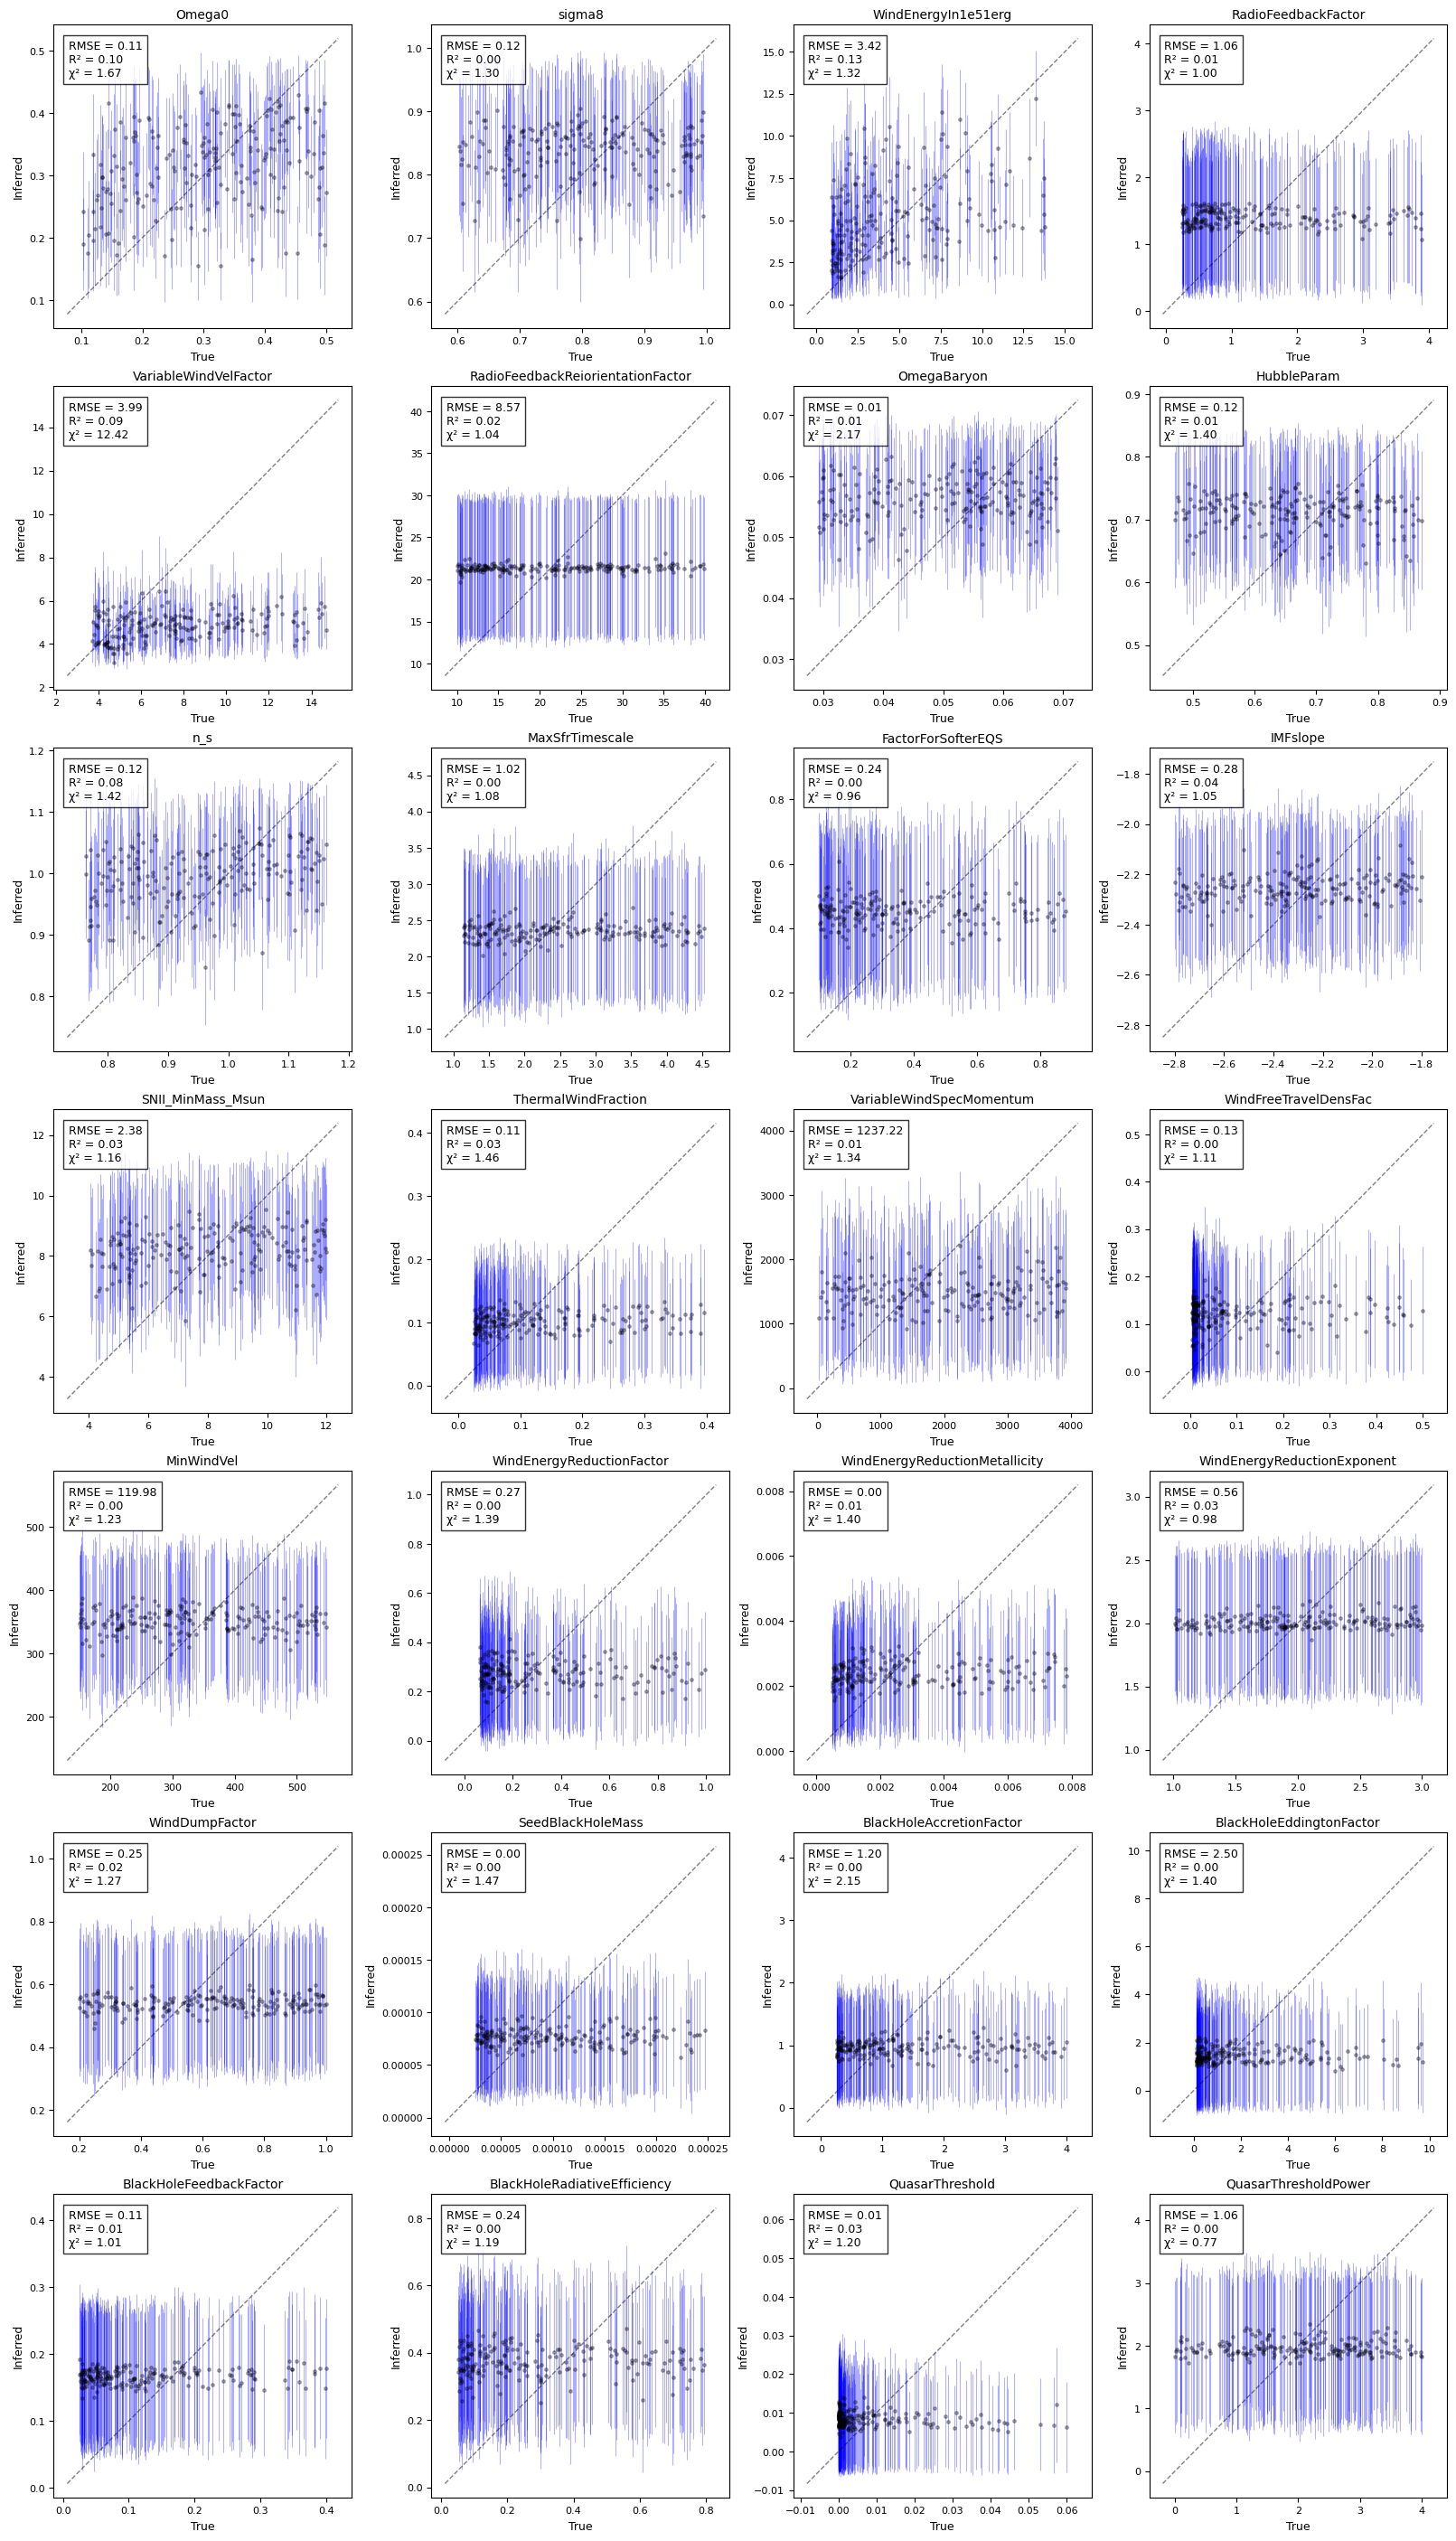

In [10]:
param_names = df_pars.columns[1:29].tolist()  # Excluding 'name' column

fig, axes = plt.subplots(7, 4, figsize=(16, 28)) 
axes = axes.flatten()

fontsize = 10  

plt.rcParams['figure.constrained_layout.use'] = True  

# Plot each parameter
for i in range(28):
    ax = axes[i]
    
    # True vs predicted with error bars
    ax.errorbar(
        theta_test[:, i].cpu().numpy(),
        all_means[:, i],
        yerr=all_stds[:, i],
        fmt='.',
        color='k',
        ecolor='blue',
        capsize=0,
        elinewidth=0.8,  
        alpha=0.3,       
        markersize=5    
    )
    
    # Add true line
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])
    ]
    ax.plot(lims, lims, '--', color='black', alpha=0.5, linewidth=1)
    
    # get metrics
    rmse = np.sqrt(np.mean((theta_test[:, i].cpu().numpy() - all_means[:, i])**2))
    r2 = np.corrcoef(theta_test[:, i].cpu().numpy(), all_means[:, i])[0, 1]**2
    chi2 = np.mean(((theta_test[:, i].cpu().numpy() - all_means[:, i])**2) / (all_stds[:, i]**2))
    
    # add metrics box in top left corner
    stats_text = f'RMSE = {rmse:.2f}\n' + \
                 f'R² = {r2:.2f}\n' + \
                 f'χ² = {chi2:.2f}'
    ax.text(0.05, 0.95, stats_text,
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8),
            verticalalignment='top',
            fontsize=fontsize-1)  # Slightly smaller font for stats
    
    # title: parameter name
    ax.set_title(param_names[i], fontsize=fontsize, pad=5)  # Reduced padding
    
    # axis labels
    ax.set_xlabel('True', fontsize=fontsize-1)
    ax.set_ylabel('Inferred', fontsize=fontsize-1)
    
    # tick labels
    ax.tick_params(axis='both', which='major', labelsize=fontsize-2)
    
    # internal padding
    ax.margins(x=0.05, y=0.05)

# subplot spacing
plt.subplots_adjust(
    left=0.01,    # Less space on left
    right=0.7,   # Less space on right
    bottom=0.05,  # Less space at bottom
    top=0.7,     # Less space at top
    wspace=0.2,   # Less space between plots horizontally
    hspace=0.2    # Less space between plots vertically
)


# Save figure with detailed filename
save_path = f'{plots_out_dir}/posterior_predictions_{config_str}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
print(save_path)
plt.show()

100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


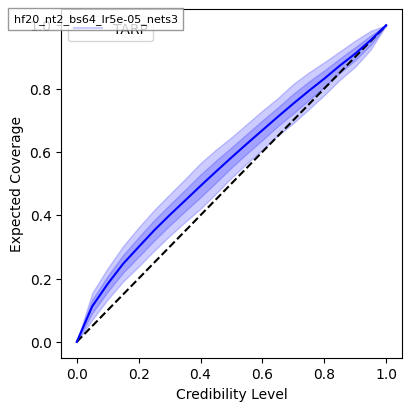

In [11]:

# coverage plots
metric = PosteriorCoverage(
    num_samples=int(4e3),
    sample_method='direct',
    labels=cam.labels,
    plot_list=["tarp"], # "coverage", "histogram", "predictions", 
    out_dir=plots_out_dir,
)

# Generate plots
figs = metric(
    posterior=posterior_ensemble,
    x=x_all[test_mask].cpu(),
    theta=theta[test_mask, :].cpu(),
    signature=f"coverage_{name}_{config_str}_"  # Add config to filename
)

config_text = config_str

# Process each figure
for i, fig in enumerate(figs):
    plt.figure(fig.number)  # Activate the figure
    plt.figtext(0.02, 0.98, config_text,
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
                verticalalignment='top')
    
    # Save each figure with type indicator
    plot_types = ["tarp"] #"coverage", "histogram", "predictions",
    plt.savefig(os.path.join(plots_out_dir, 
                f'metric_{plot_types[i]}_{name}_{config_str}_bestnn_test.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()